# Costa Rican Household Poverty Level Prediction

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#feature_engineering">Feature Engineering</a></li>
</ul>

<a id='intro'></a>
# Introduction

> The Inter-American Development Bank is asking the Kaggle community for help with income qualification for some of the world's poorest families. Are you up for the challenge?

> Here's the backstory: Many social programs have a hard time making sure the right people are given enough aid. It’s especially tricky when a program focuses on the poorest segment of the population. The world’s poorest typically can’t provide the necessary income and expense records to prove that they qualify.

> In Latin America, one popular method uses an algorithm to verify income qualification. It’s called the Proxy Means Test (or PMT). With PMT, agencies use a model that considers a family’s observable household attributes like the material of their walls and ceiling, or the assets found in the home to classify them and predict their level of need.

> While this is an improvement, accuracy remains a problem as the region’s population grows and poverty declines.
Beyond Costa Rica, many countries face this same problem of inaccurately assessing social need.



## Problem and Data Explanation
> The data for this competition is provided in two files: train.csv and test.csv. The training set has 9557 rows and 143 columns while the testing set has 23856 rows and 142 columns. Each row represents one individual and each column is a feature, either unique to the individual, or for the household of the individual. The training set has one additional column, Target, which represents the poverty level on a 1-4 scale and is the label for the competition. A value of 1 is the most extreme poverty.

This is a supervised multi-class classification machine learning problem:
- Supervised: provided with the labels for the training data
- Multi-class classification: Labels are discrete values with 4 classes

### Objective
> The objective is to predict poverty on a household level. We are given data on the individual level with each individual having unique features but also information about their household. In order to create a dataset for the task, we'll have to perform some aggregations of the individual data for each household. Moreover, we have to make a prediction for every individual in the test set, but "ONLY the heads of household are used in scoring" which means we want to predict poverty on a household basis.

The Target values represent poverty levels as follows:

1 = extreme poverty 
2 = moderate poverty 
3 = vulnerable households 
4 = non vulnerable households

The explanations for all 143 columns can be found in the [competition documentation](https://www.kaggle.com/c/costa-rican-household-poverty-prediction) , but a few to note are below:

- **Id** : a unique identifier for each individual, this should not be a feature that we use!
- **idhogar** : a unique identifier for each household. This variable is not a feature, but will be used to group individuals by - household as all individuals in a household will have the same identifier.
- **parentesco1** : indicates if this person is the head of the household.
- **Target** : the label, which should be equal for all members in a household

When we make a model, we'll train on a household basis with the label for each household the poverty level of the head of household. The raw data contains a mix of both household and individual characteristics and for the individual data, we will have to find a way to aggregate this for each household. Some of the individuals belong to a household with no head of household which means that unfortunately we can't use this data for training. These issues with the data are completely typical of real-world data and hence this problem is great preparation for the datasets you'll encounter in a data science job!



In [1]:
# Import modules
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set a few plotting defaults
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18
plt.rcParams['patch.edgecolor'] = 'k'

In [2]:
# Read the data
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

# To display maximum number of columns 
pd.options.display.max_columns = 150

In [3]:
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,no,10,no,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,8,12,no,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,8,no,11,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


<a id='wrangling'></a>
# Data Wrangling

In [4]:
# Shape of train and test data
print("Train:",train.shape)
print("Test:",test.shape)

Train: (9557, 143)
Test: (23856, 142)


In [5]:
# To get the information of the data 
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


This tells us there are 130 integer columns, 8 float (numeric) columns, and 5 object columns. The integer columns probably represent Boolean variables (that take on either 0 or 1) or ordinal variables with discrete ordered values. The object columns might pose an issue because they cannot be fed directly into a machine learning model.

Let's glance at the test data which has many more rows (individuals) than the train. It does have one fewer column because there's no Target!

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Columns: 142 entries, Id to agesq
dtypes: float64(8), int64(129), object(5)
memory usage: 25.8+ MB


 ### Null and missing values

In [7]:
# Check for Null values
train.isnull().sum()

Id                    0
v2a1               6860
hacdor                0
rooms                 0
hacapo                0
v14a                  0
refrig                0
v18q                  0
v18q1              7342
r4h1                  0
r4h2                  0
r4h3                  0
r4m1                  0
r4m2                  0
r4m3                  0
r4t1                  0
r4t2                  0
r4t3                  0
tamhog                0
tamviv                0
escolari              0
rez_esc            7928
hhsize                0
paredblolad           0
paredzocalo           0
paredpreb             0
pareddes              0
paredmad              0
paredzinc             0
paredfibras           0
                   ... 
bedrooms              0
overcrowding          0
tipovivi1             0
tipovivi2             0
tipovivi3             0
tipovivi4             0
tipovivi5             0
computer              0
television            0
mobilephone           0
qmobilephone    

Number of tablets household owns(v18q1) , Monthly rent payment(v2a1), Years behind in school(rez_esc) have most missing values.

<a id='eda'></a>
# Exploratory Data Analysis

### Integer Columns
Let's look at the distribution of unique values in the integer columns. For each column, we'll count the number of unique values and show the result in a bar plot.

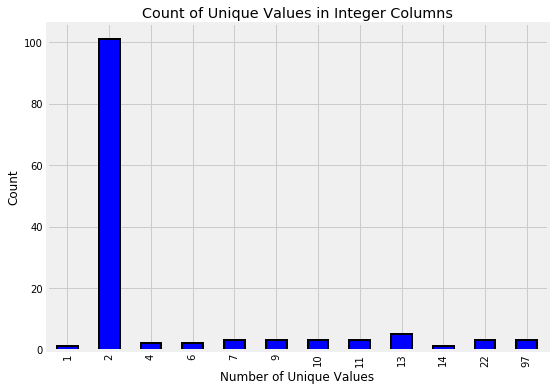

In [8]:
train.select_dtypes(np.int64).nunique().value_counts().sort_index().plot.bar(color = 'blue', 
                                                                             figsize = (8, 6),
                                                                            edgecolor = 'k', linewidth = 2);
plt.xlabel('Number of Unique Values'); plt.ylabel('Count');
plt.title('Count of Unique Values in Integer Columns');

The columns with only 2 unique values represent Booleans (0 or 1). In a lot of cases, this boolean information is already on a household level. For example, the refrig column says whether or not the household has a refrigerator. When it comes time to make features from the Boolean columns that are on the household level, we will not need to aggregate these. However, the Boolean columns that are on the individual level will need to be aggregated.



### Float Columns
Another column type is floats which represent continuous variables. We can make a quick distribution plot to show the distribution of all float columns. We'll use an OrderedDict to map the poverty levels to colors because this keeps the keys and values in the same order as we specify (unlike a regular Python dictionary).

The following graphs shows the distributions of the float columns colored by the value of the Target. With these plots, we can see if there is a significant difference in the variable distribution depending on the household poverty level.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


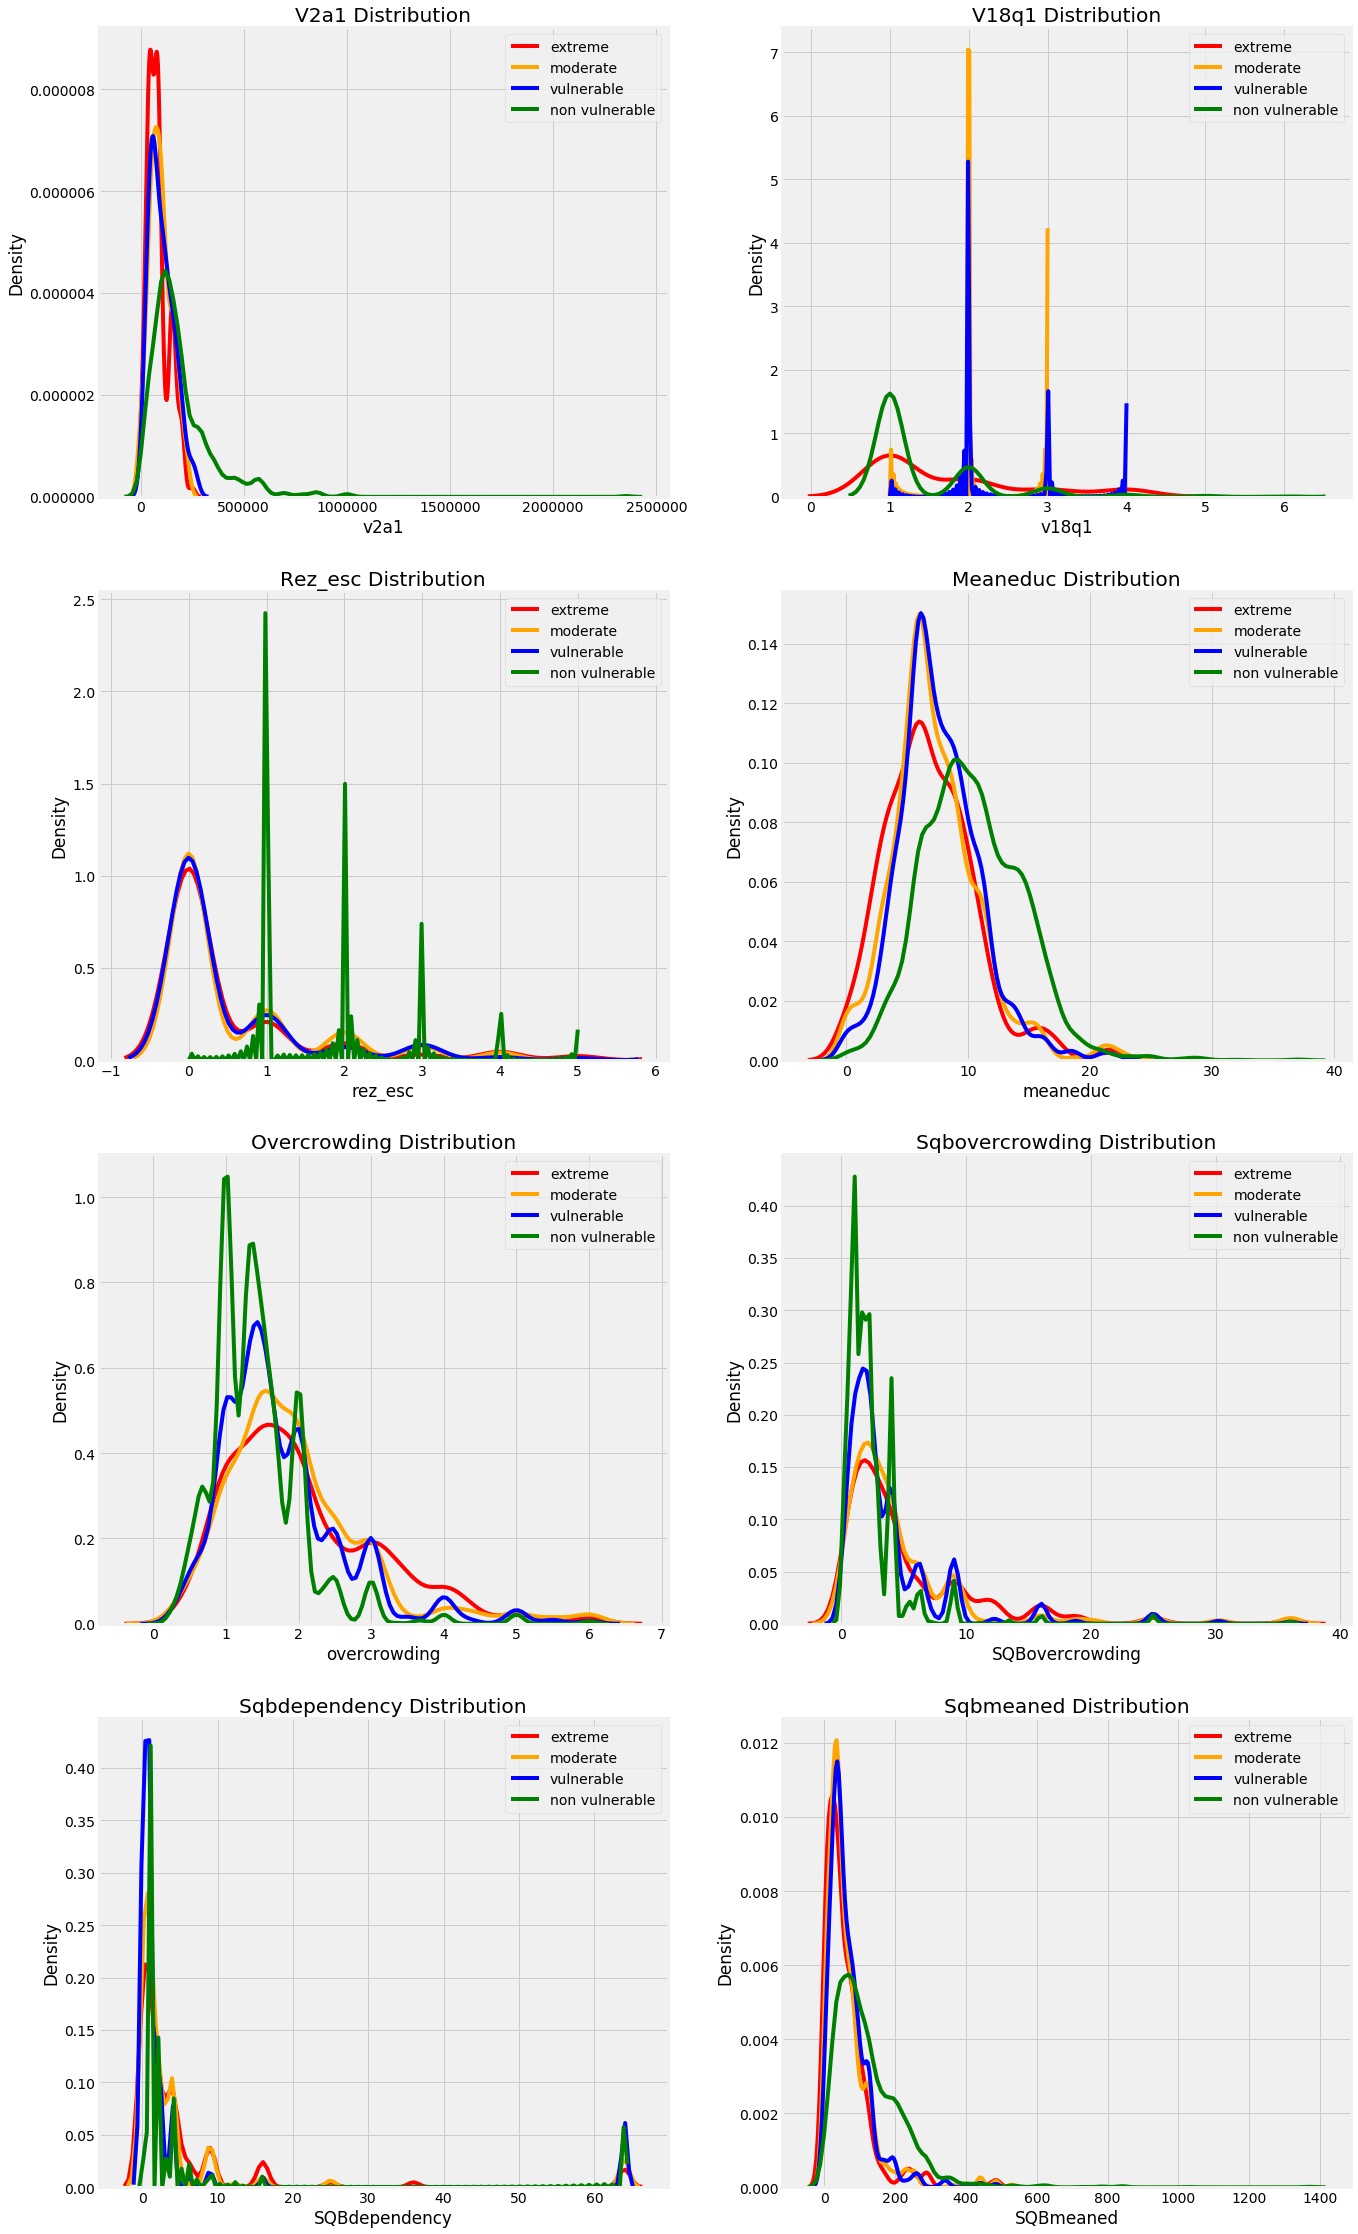

In [9]:
from collections import OrderedDict

plt.figure(figsize = (20, 16))
plt.style.use('fivethirtyeight')

# Color mapping
colors = OrderedDict({1: 'red', 2: 'orange', 3: 'blue', 4: 'green'})
poverty_mapping = OrderedDict({1: 'extreme', 2: 'moderate', 3: 'vulnerable', 4: 'non vulnerable'})

# Iterate through the float columns
for i, col in enumerate(train.select_dtypes('float')):
    ax = plt.subplot(4, 2, i + 1)
    # Iterate through the poverty levels
    for poverty_level, color in colors.items():
        # Plot each poverty level as a separate line
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(), 
                    ax = ax, color = color, label = poverty_mapping[poverty_level])
        
    plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')

plt.subplots_adjust(top = 2)

Later on we'll calculate correlations between the variables and the Target to gauge the relationships between the features, but these plots can already give us a sense of which variables may be most "relevant" to a model. For example, the  meaneduc, representing the average education of the adults in the household appears to be related to the poverty level: a higher average adult education leads to higher values of the target which are less severe levels of poverty. The theme of the importance of education is one we will come back to again and again in this notebook!

- We can see that non vulnarable have more numbers of years of education
-  We can see that there are less number of people living in one room in the non vulnarable catogery and it increases as the poverty increases

### Object Columns

In [10]:
train.select_dtypes('object').head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


The Id and idhogar object types make sense because these are identifying variables. However, the other columns seem to be a mix of strings and numbers which we'll need to address before doing any machine learning. According to the documentation for these columns:

- dependency: Dependency rate, calculated = (number of members of the household younger than 19 or older than 64)/(number of member of household between 19 and 64)
- edjefe: years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0
- edjefa: years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0
These explanations clear up the issue. For these three variables, "yes" = 1 and "no" = 0. We can correct the variables using a mapping and convert to floats.

In [11]:
mapping = {"yes": 1, "no": 0}

# Apply same operation to both train and test
for df in [train, test]:
    # Fill in the values with the correct mapping
    df['dependency'] = df['dependency'].replace(mapping).astype(np.float64)
    df['edjefa'] = df['edjefa'].replace(mapping).astype(np.float64)
    df['edjefe'] = df['edjefe'].replace(mapping).astype(np.float64)

train[['dependency', 'edjefa', 'edjefe']].describe()

,dependency,edjefa,edjefe
count,9557.000000,9557.000000,9557.000000
mean,1.149550,2.896830,5.096788
std,1.605993,4.612056,5.246513
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,0.000000,6.000000
75%,1.333333,6.000000,9.000000
max,8.000000,21.000000,21.000000


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


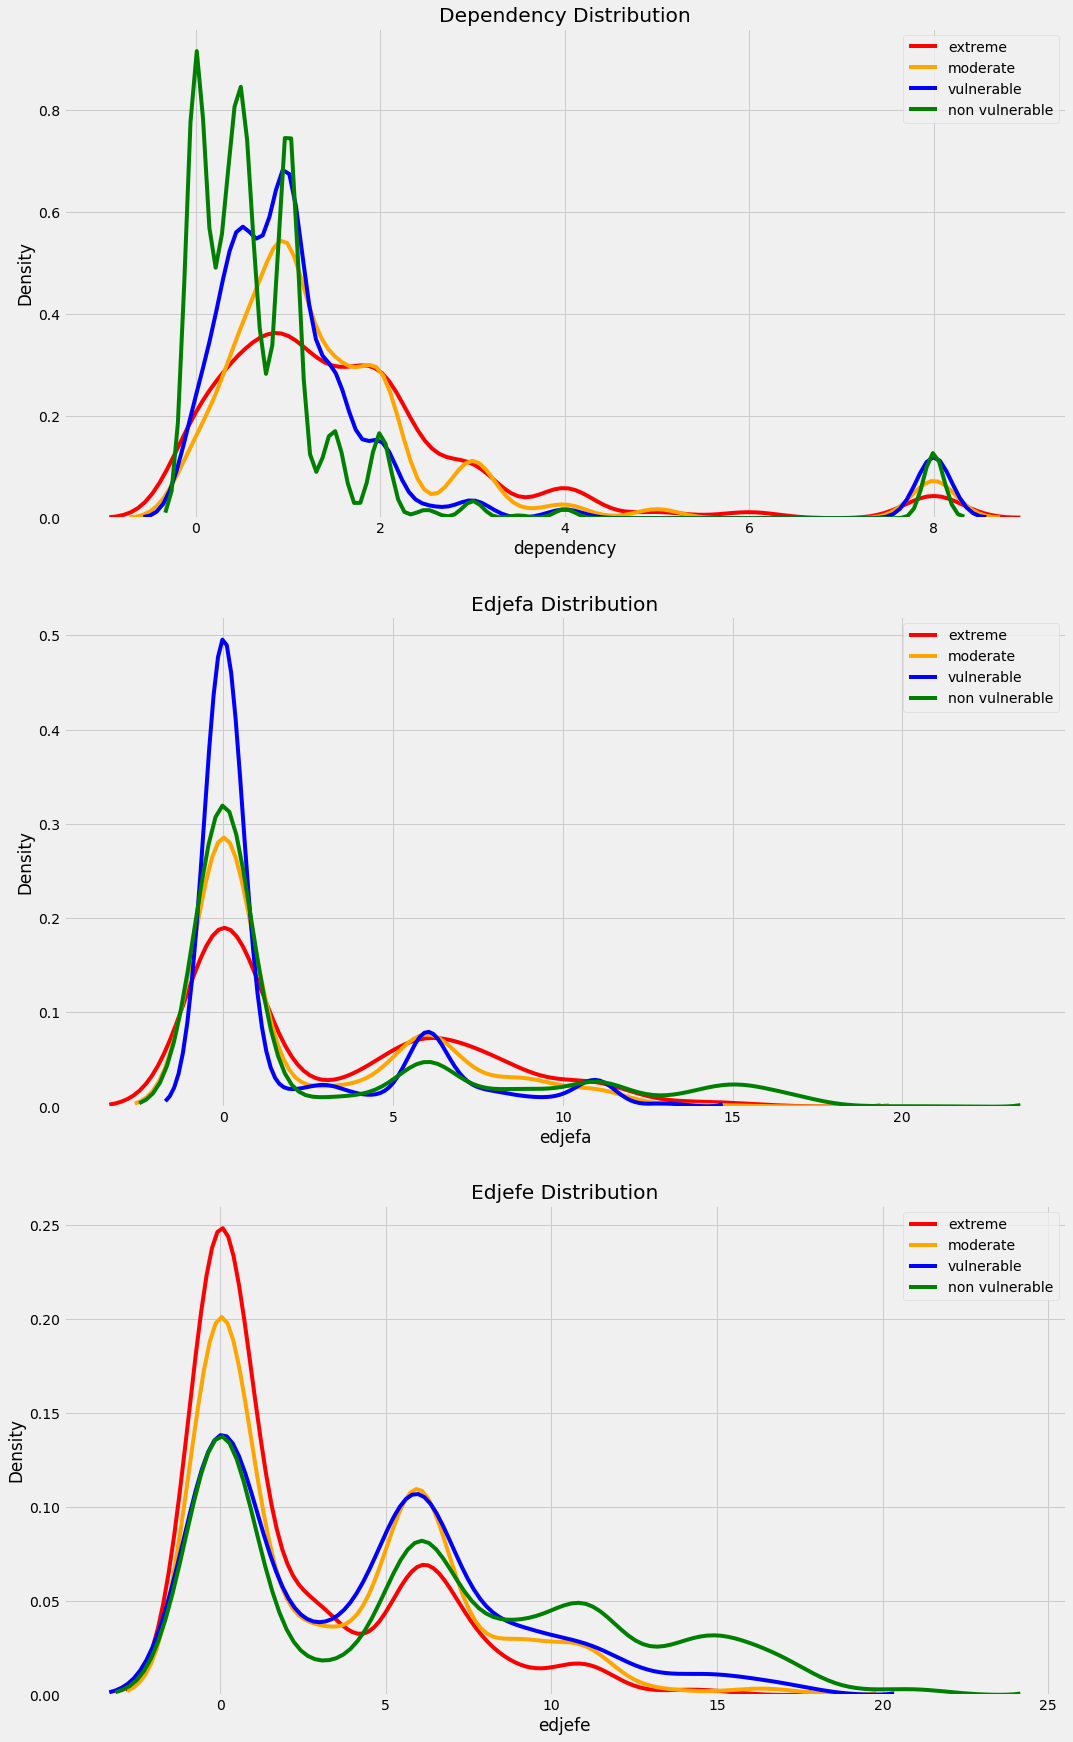

In [12]:
plt.figure(figsize = (16, 12))

# Iterate through the float columns
for i, col in enumerate(['dependency', 'edjefa', 'edjefe']):
    ax = plt.subplot(3, 1, i + 1)
    # Iterate through the poverty levels
    for poverty_level, color in colors.items():
        # Plot each poverty level as a separate line
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(), 
                    ax = ax, color = color, label = poverty_mapping[poverty_level])
        
    plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')

plt.subplots_adjust(top = 2)

Here we can see that
- years of education of male and female head of household is very low in extreme poverty and very high in non vulnerable.
- dependency is very low in non vulnareable.

These variables are now correctly represented as numbers and can be fed into a machine learning model.

### Join Train and Test Set
To make operations like that above a little easier, we'll join together the training and testing dataframes. This is important once we start feature engineering because we want to apply the same operations to both dataframes so we end up with the same features. Later we can separate out the sets based on the Target.

In [13]:
# Add null Target column to test
test['Target'] = np.nan
train_len = len(train)
data =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

## Exploring Label Distribution
Next, we can get an idea of how imbalanced the problem is by looking at the distribution of labels. There are four possible integer levels, indicating four different levels of poverty. To look at the correct labels, we'll subset only to the columns where parentesco1 == 1 because this is the head of household, the correct label for each household.

The bar plot below shows the distribution of training labels (since there are no testing labels).

1.0     222
2.0     442
3.0     355
4.0    1954
Name: Target, dtype: int64

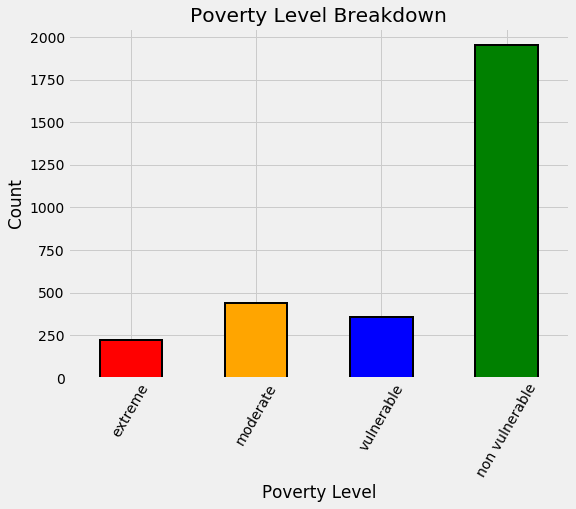

In [14]:
# Heads of household
heads = data.loc[data['parentesco1'] == 1].copy()

# Labels for training
train_labels = data.loc[(data['Target'].notnull()) & (data['parentesco1'] == 1), ['Target', 'idhogar']]

# Value counts of target
label_counts = train_labels['Target'].value_counts().sort_index()

# Bar plot of occurrences of each label
label_counts.plot.bar(figsize = (8, 6), 
                      color = colors.values(),
                      edgecolor = 'k', linewidth = 2)

# Formatting
plt.xlabel('Poverty Level'); plt.ylabel('Count'); 
plt.xticks([x - 1 for x in poverty_mapping.keys()], 
           list(poverty_mapping.values()), rotation = 60)
plt.title('Poverty Level Breakdown');

label_counts

We are dealing with an imbalanced class problem. There are many more households that classify as non vulnerable than in any other category. The extreme poverty class is the smallest (I guess this should make us optimistic!).

One problem with imbalanced classification problems is that the machine learning model can have a difficult time predicting the minority classes because it sees far less examples. Think about this in human terms: if we are classifiying poverty and we see far more cases of no poverty than extreme poverty, it will make it more difficult for us to identify the high poverty households because of less exposure. One potential method to address class imbalanceds is through oversampling (which is covered in more advanced notebooks).

## Addressing Wrong Labels (Not Needed Part)
As with any realistic dataset, the Costa Rican Poverty data has some issues. Typically, 80% of a data science project will be spent cleaning data and fixing anomalies/errors. These can be either human entry errors, measurement errors, or sometimes just extreme values that are correct but stand out. For this problem, some of the labels are not correct because individuals in the same household have a different poverty level. We're not told why this may be the case, but we are told to use the head of household as the true label.

That information makes our job much easier, but in a real-world problem, we would have to figure out the reason Why the labels are wrong and how to address the issue on our own. This section fixes the issue with the labels although it is not strictly necessary: I kept it in the notebook just to show how we may deal with this issue.

Identify Errors
First we need to find the errors before we can correct them. To find the households with different labels for family members, we can group the data by the household and then check if there is only one unique value of the Target.

In [15]:
# Groupby the household and figure out the number of unique values
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

# Households where targets are not all equal
not_equal = all_equal[all_equal != True]
print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

There are 85 households where the family members do not all have the same target.


In [16]:
# Example
train[train['idhogar'] == not_equal.index[0]][['idhogar', 'parentesco1', 'Target']]

,idhogar,parentesco1,Target
7651,0172ab1d9,0,3
7652,0172ab1d9,0,2
7653,0172ab1d9,0,3
7654,0172ab1d9,1,3
7655,0172ab1d9,0,2


The organizers tell us that the correct label is that for the head of household, where parentesco1 == 1. For this household, the correct label is 3 for all members. We can correct this (as shown later) by reassigning all the individuals in this household the correct poverty level. In the real-world, you might have to make the tough decision of how to address the problem by yourself (or with the help of your team).

### Families without Heads of Household
We can correct all the label discrepancies by assigning the individuals in the same household the label of the head of household. But wait, you may ask: "What if there are households without a head of household? And what if the members of those households have differing values of the label?"

Well, since you asked, let's investigate exactly that question!

In [17]:
households_leader = train.groupby('idhogar')['parentesco1'].sum()

# Find households without a head
households_no_head = train.loc[train['idhogar'].isin(households_leader[households_leader == 0].index), :]

print('There are {} households without a head.'.format(households_no_head['idhogar'].nunique()))

There are 15 households without a head.


In [18]:
# Find households without a head and where labels are different
households_no_head_equal = households_no_head.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)
print('{} Households with no head have different labels.'.format(sum(households_no_head_equal == False)))

0 Households with no head have different labels.


Well that's a relief! This means that we don't have to worry about a household both where there is no head AND the members have different values of the label! For this problem, according to the organizers, if a household does not have a head, then there is no true label. Therefore, we actually won't use any of the households without a head for training Nonetheless, it's still a good exercise to go through this process of investigating the data!

### Correct Errors
Now we can correct labels for the households that do have a head AND the members have different poverty levels

In [19]:
# Iterate through each household
for household in not_equal.index:
    # Find the correct label (for the head of household)
    true_target = int(train[(train['idhogar'] == household) & (train['parentesco1'] == 1.0)]['Target'])
    
    # Set the correct label for all members in the household
    train.loc[train['idhogar'] == household, 'Target'] = true_target
    
    
# Groupby the household and figure out the number of unique values
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

# Households where targets are not all equal
not_equal = all_equal[all_equal != True]
print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

There are 0 households where the family members do not all have the same target.


Since we are only going to use the heads of household for the labels, this step is not completely necessary but it shows a workflow for correcting data errors like you may encounter in real life. Don't consider it extra work, just practice for your career!

### Missing Variables
One of the most important steps of exploratory data analysis is finding missing values in the data and determining how to handle them. Missing values have to be filled in before we use a machine learning model and we need to think of the best strategy for filling them in based on the feature: this is where we'll have to start digging into the data definitions.

First we can look at the percentage of missing values in each column.

In [20]:
# Number of missing in each column
missing = pd.DataFrame(data.isnull().sum()).rename(columns = {0: 'total'})

# Create a percentage missing
missing['percent'] = missing['total'] / len(data)

missing.sort_values('percent', ascending = False).head(10).drop('Target')

,total,percent
rez_esc,27581,0.825457
v18q1,25468,0.762218
v2a1,24263,0.726154
SQBmeaned,36,0.001077
meaneduc,36,0.001077
hogar_adul,0,0.000000
parentesco10,0,0.000000
parentesco11,0,0.000000
parentesco12,0,0.000000


We don't have to worry about the Target becuase we made that NaN for the test data. However, we do need to address the other 3 columns with a high percentage of missing values.

### v18q1: Number of tablets

Let's start with v18q1 which indicates the number of tablets owned by a family. We can look at the value counts of this variable. Since this is a household variable, it only makes sense to look at it on a household level, so we'll only select the rows for the head of household.

### Function to Plot Value Counts¶
Since we might want to plot value counts for different columns, we can write a simple function that will do it for us!

In [21]:
def plot_value_counts(df, col, heads_only = False):
    """Plot value counts of a column, optionally with only the heads of a household"""
    # Select heads of household
    if heads_only:
        df = df.loc[df['parentesco1'] == 1].copy()
        
    plt.figure(figsize = (8, 6))
    df[col].value_counts().sort_index().plot.bar(color = 'blue',
                                                 edgecolor = 'k',
                                                 linewidth = 2)
    plt.xlabel(f'{col}'); plt.title(f'{col} Value Counts'); plt.ylabel('Count')
    plt.show();

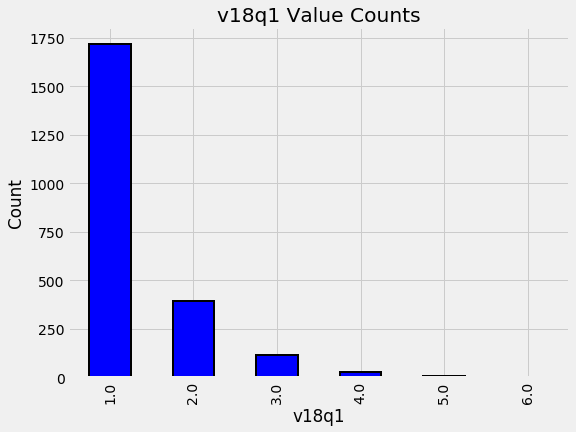

In [22]:
plot_value_counts(heads, 'v18q1')

It looks like the most common number of tablets to own is 1 if we go only by the data that is present. However, we also need to think about the data that is missing. In this case, it could be that families with a nan in this category just do not own a tablet! If we look at the data definitions, we see that v18q indicates whether or not a family owns a tablet. We should investigate this column combined with the number of tablets to see if our hypothesis holds.

We can groupby the value of v18q (which is 1 for owns a tablet and 0 for does not) and then calculate the number of null values for v18q1. This will tell us if the null values represent that the family does not own a tablet.

In [23]:
heads.groupby('v18q')['v18q1'].apply(lambda x: x.isnull().sum())

v18q
0    8044
1       0
Name: v18q1, dtype: int64

Well, that solves the issue! Every family that has nan for v18q1 does not own a tablet. Therefore, we can fill in this missing value with zero.

In [24]:
data['v18q1'] = data['v18q1'].fillna(0)

### v2a1: Monthly rent payment

The next missing column is v2a1 which represents the montly rent payment.

In addition to looking at the missing values of the monthly rent payment, it will be interesting to also look at the distribution of tipovivi_, the columns showing the ownership/renting status of the home. For this plot, we show the ownership status of those homes with a nan for the monthyl rent payment.

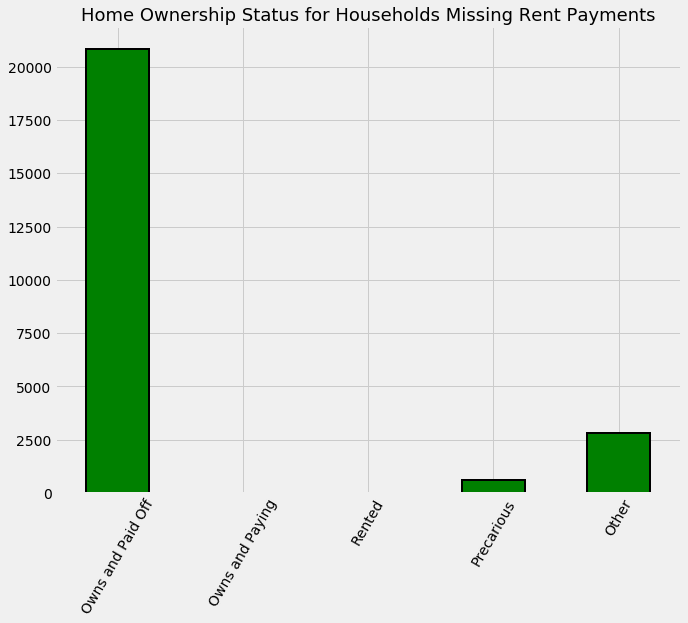

In [25]:
# Variables indicating home ownership
own_variables = [x for x in data if x.startswith('tipo')]


# Plot of the home ownership variables for home missing rent payments
data.loc[data['v2a1'].isnull(), own_variables].sum().plot.bar(figsize = (10, 8),
                                                                        color = 'green',
                                                              edgecolor = 'k', linewidth = 2);
plt.xticks([0, 1, 2, 3, 4],
           ['Owns and Paid Off', 'Owns and Paying', 'Rented', 'Precarious', 'Other'],
          rotation = 60)
plt.title('Home Ownership Status for Households Missing Rent Payments', size = 18);

The meaning of the home ownership variables is below:

- tipovivi1, =1 own and fully paid house
- tipovivi2, "=1 own,  paying in installments"
- tipovivi3, =1 rented
- tipovivi4, =1 precarious
- tipovivi5, "=1 other(assigned,  borrowed)"

We've solved the issue! Well, mostly: the households that do not have a monthly rent payment generally own their own home. In a few other situations, we are not sure of the reason for the missing information.

For the houses that are owned and have a missing monthly rent payment, we can set the value of the rent payment to zero. For the other homes, we can leave the missing values to be imputed but we'll add a flag (Boolean) column indicating that these households had missing values.

In [26]:
# Fill in households that own the house with 0 rent payment
data.loc[(data['tipovivi1'] == 1), 'v2a1'] = 0

# Create missing rent payment column
data['v2a1-missing'] = data['v2a1'].isnull()

data['v2a1-missing'].value_counts()

False    29994
True      3419
Name: v2a1-missing, dtype: int64

### rez_esc: years behind in school

The last column with a high percentage of missing values is rez_esc indicating years behind in school. For the families with a null value, is possible that they have no children currently in school. Let's test this out by finding the ages of those who have a missing value in this column and the ages of those who do not have a missing value.

In [27]:
data.loc[data['rez_esc'].notnull()]['age'].describe()

count    5832.000000
mean       12.185700
std         3.198618
min         7.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        17.000000
Name: age, dtype: float64

What this tells us is that the oldest age with a missing value is 17. For anyone older than this, maybe we can assume that they are simply not in school. Let's look at the ages of those who have a missing value.

In [28]:
data.loc[data['rez_esc'].isnull()]['age'].describe()

count    27581.000000
mean        39.110656
std         20.983114
min          0.000000
25%         24.000000
50%         38.000000
75%         54.000000
max         97.000000
Name: age, dtype: float64

If we read through some of the discussions for this competition, we learn that this variable is only defined for individuals between 7 and 19. Anyone younger or older than this range presumably has no years behind and therefore the value should be set to 0. For this variable, if the individual is over 19 and they have a missing value, or if they are younger than 7 and have a missing value we can set it to zero. For anyone else, we'll leave the value to be imputed and add a boolean flag.

In [29]:
# If individual is over 19 or younger than 7 and missing years behind, set it to 0
data.loc[((data['age'] > 19) | (data['age'] < 7)) & (data['rez_esc'].isnull()), 'rez_esc'] = 0

# Add a flag for those between 7 and 19 with a missing value
data['rez_esc-missing'] = data['rez_esc'].isnull()


There is also one outlier in the rez_esc column. Again, if we read through the competition discussions, we learn that the maximum value for this variable is 5. Therefore, any values above 5 should be set to 5.

In [30]:
data.loc[data['rez_esc'] > 5, 'rez_esc'] = 5

### Plot Two Categorical Variables
To show how two categorical variables interact with one another, there are a number of plotting options: scatterplots, faceted bar plots, boxplots, etc. I wasn't satisfied with any of these choices so I wrote the function below, which essentially is a scatterplot of two categoricals where the size of the points represent the percentage of a given y-value represented by each x-value.

In [31]:
# Function for better scatter plot
def plot_categoricals(x, y, data, annotate = True):
    """Plot counts of two categoricals.
    Size is raw count for each grouping.
    Percentages are for a given value of y."""
    
    # Raw counts 
    raw_counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = False))
    raw_counts = raw_counts.rename(columns = {x: 'raw_count'})
    
    # Calculate counts for each group of x and y
    counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = True))
    
    # Rename the column and reset the index
    counts = counts.rename(columns = {x: 'normalized_count'}).reset_index()
    counts['percent'] = 100 * counts['normalized_count']
    
    # Add the raw count
    counts['raw_count'] = list(raw_counts['raw_count'])
    
    plt.figure(figsize = (14, 10))
    # Scatter plot sized by percent
    plt.scatter(counts[x], counts[y], edgecolor = 'k', color = 'lightgreen',
                s = 100 * np.sqrt(counts['raw_count']), marker = 'o',
                alpha = 0.6, linewidth = 1.5)
    
    if annotate:
        # Annotate the plot with text
        for i, row in counts.iterrows():
            # Put text with appropriate offsets
            plt.annotate(xy = (row[x] - (1 / counts[x].nunique()), 
                               row[y] - (0.15 / counts[y].nunique())),
                         color = 'navy',
                         s = f"{round(row['percent'], 1)}%")
        
    # Set tick marks
    plt.yticks(counts[y].unique())
    plt.xticks(counts[x].unique())
    
    # Transform min and max to evenly space in square root domain
    sqr_min = int(np.sqrt(raw_counts['raw_count'].min()))
    sqr_max = int(np.sqrt(raw_counts['raw_count'].max()))
    
    # 5 sizes for legend
    msizes = list(range(sqr_min, sqr_max,
                        int(( sqr_max - sqr_min) / 5)))
    markers = []
    
    # Markers for legend
    for size in msizes:
        markers.append(plt.scatter([], [], s = 100 * size, 
                                   label = f'{int(round(np.square(size) / 100) * 100)}', 
                                   color = 'lightgreen',
                                   alpha = 0.6, edgecolor = 'k', linewidth = 1.5))
        
    # Legend and formatting
    plt.legend(handles = markers, title = 'Counts',
               labelspacing = 3, handletextpad = 2,
               fontsize = 16,
               loc = (1.10, 0.19))
    
    plt.annotate(f'* Size represents raw count while % is for a given y value.',
                 xy = (0, 1), xycoords = 'figure points', size = 10)
    
    # Adjust axes limits
    plt.xlim((counts[x].min() - (6 / counts[x].nunique()), 
              counts[x].max() + (6 / counts[x].nunique())))
    plt.ylim((counts[y].min() - (4 / counts[y].nunique()), 
              counts[y].max() + (4 / counts[y].nunique())))
    plt.grid(None)
    plt.xlabel(f"{x}"); plt.ylabel(f"{y}"); plt.title(f"{y} vs {x}");

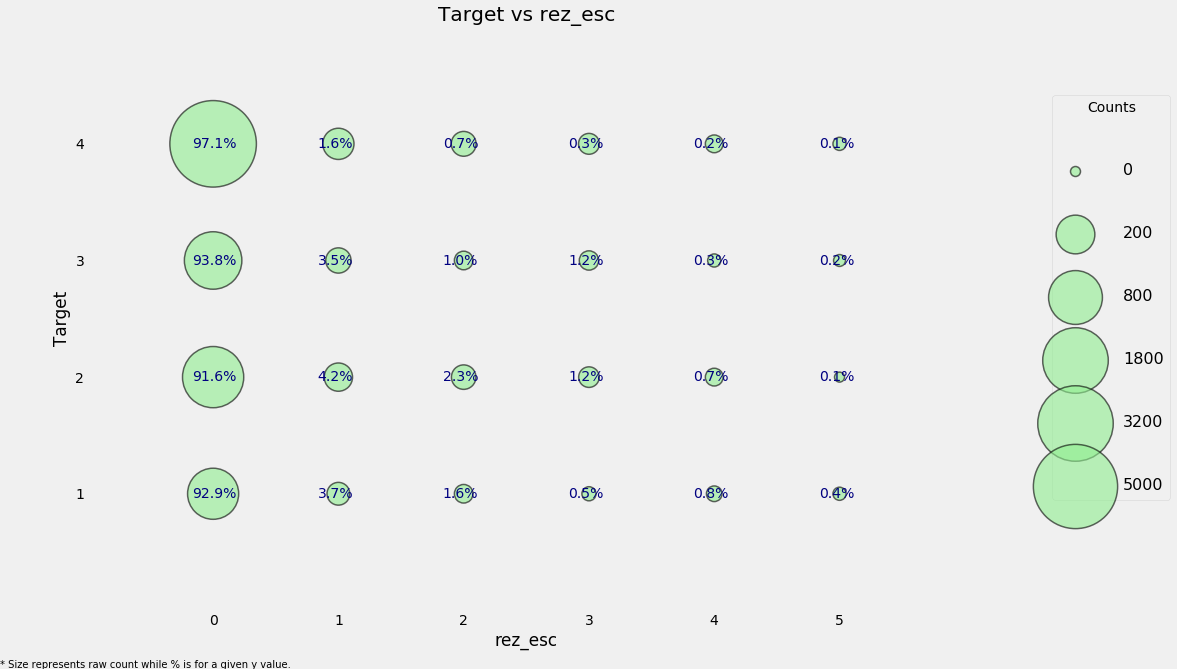

In [32]:
plot_categoricals('rez_esc', 'Target', data);

The size of the markers represents the raw count. To read the plot, choose a given y-value and then read across the row. For example, with a poverty level of 1, 93% of individuals have no years behind with a total count of around 800 individuals and about 0.4% of individuals are 5 years behind with about 50 total individuals in this category. This plot attempts to show both the overall counts and the within category proportion; it's not perfect , but I gave it a shot!

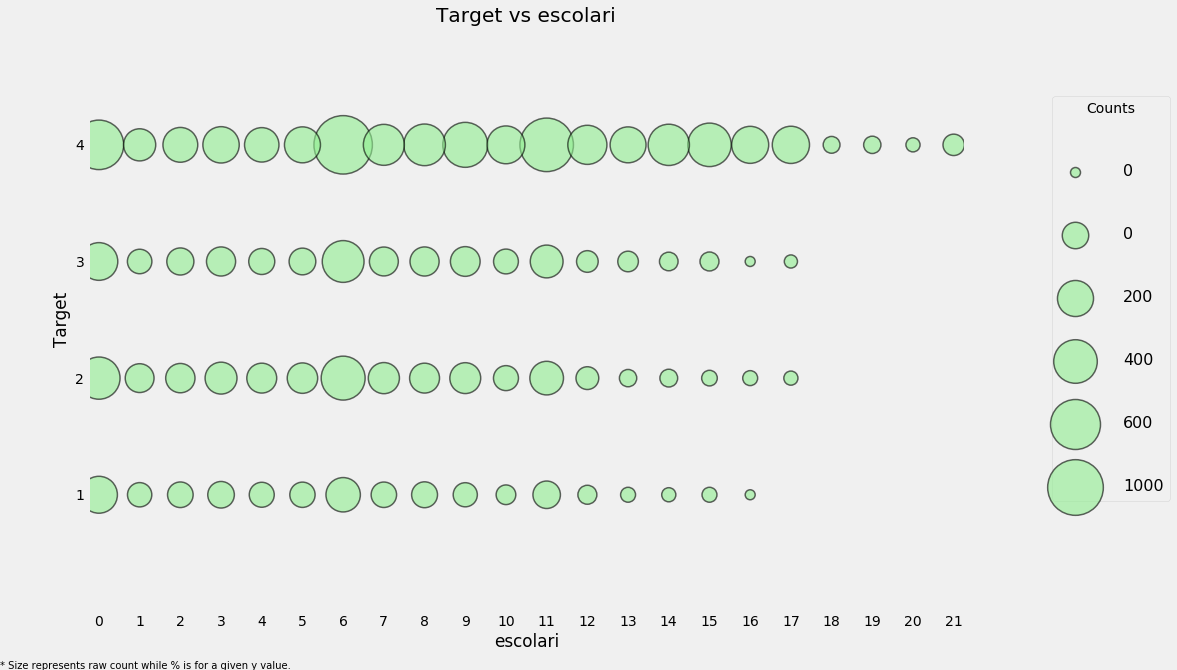

In [33]:
# Poverty vs years of schooling
plot_categoricals('escolari', 'Target', data, annotate = False)

The remaining missing values in each column will be filled in, a process known as Imputation. There are several types of imputation commonly used, and one of the simplest and most effective methods is to fill in the missing values with the median of the column.

As a final step with the missing values, we can plot the distribution of target for the case where either of these values are missing.

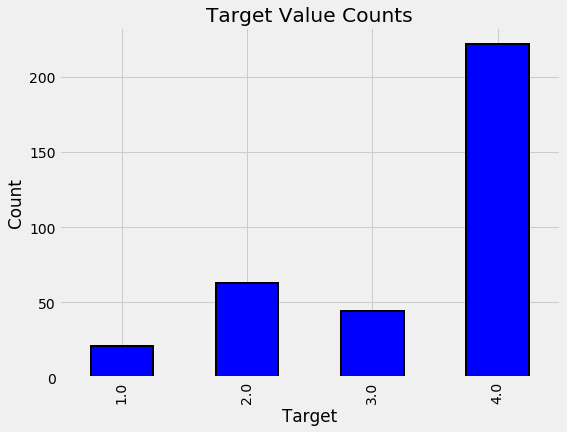

In [34]:
plot_value_counts(data[(data['rez_esc-missing'] == 1)], 
                  'Target')

The distribution here seems to match that for all the data at large.

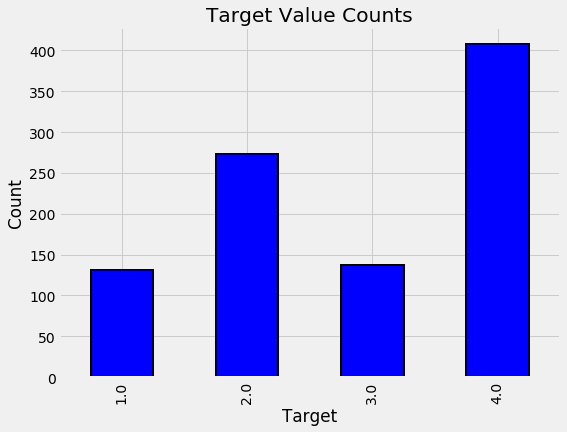

In [35]:
plot_value_counts(data[(data['v2a1-missing'] == 1)], 
                  'Target')

This looks like it could be an indicator of more poverty given the higher prevalence of 2: moderate poverty.

This represents an important point: sometimes the missing information is just as important as the information you are given.

<a id='feature_engineering'></a>
# Feature Engineering

There is plenty more exploratory data analysis we can do, but first we should work on consolidating our data at a household level. We already have some of the information for each household, but for training, we will need all of the information summarized for each household. This means grouping the individuals in a house (groupby) and performing an aggregation (agg) of the individual variables.

### Column Definitions
Sometimes in data science we have to get our hands dirty digging through the data or do tedious tasks that take a lot of time. This is that part of the analysis: we have to define the columns that are at an individual level and at a household level using the data decsriptions. There is simply no other way to identify which variables at are the household level than to go through the variables themselves in the data description. Except, I've already done this for you, so all you have to do is copy and paste!

We'll define different variables because we need to treat some of them in a different manner. Once we have the variables defined on each level, we can work to start aggregating them as needed.

The process is as follows

1. Break variables into household level and invididual level
2. Find suitable aggregations for the individual level data
    - Ordinal variables can use statistical aggregations
    - Boolean variables can also be aggregated but with fewer stats
3. Join the individual aggregations to the household level data

### Define Variable Categories
There are several different categories of variables:

1. Individual Variables: these are characteristics of each individual rather than the household
    - Boolean: Yes or No (0 or 1)
    - Ordered Discrete: Integers with an ordering
2. Household variables
    - Boolean: Yes or No
    - Ordered Discrete: Integers with an ordering
    - Continuous numeric
3. Squared Variables: derived from squaring variables in the data
4. Id variables: identifies the data and should not be used as features

Below we manually define the variables in each category. This is a little tedious, but also necessary.